<a href="https://colab.research.google.com/github/merveenoyan/smol-vision/blob/main/ShieldGemma_2_for_Vision_LM_Safety.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src='https://storage.googleapis.com/gweb-developer-goog-blog-assets/images/SheildGemma2_WagtailBlog_RD1_V01a.original.png' />

## ShieldGemma 2

ShieldGemma 2 is a safety checker for vision language models. Input images to vision language models in production can contain unsafe themes, and ShieldGemma 2 can classify them before inputting those images to vision language models.

In this notebook we will go through how to briefly infer with ShieldGemma 2.

**Trigger Warning**: This notebook can contain keywords that can cause triggers.

We need to upgrade transformers and login to Hugging Face since this model is gated.

In [ ]:
!pip install -U -q transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 109.0 MB/s eta 0:00:00


In [ ]:
from huggingface_hub import notebook_login

notebook_login()

We can initialize ShieldGemma 2 model and processor as follows.

In [ ]:
from transformers import AutoProcessor, ShieldGemma2ForImageClassification
from PIL import Image
import requests
import torch
model_id = "google/shieldgemma-2-4b-it"
model = ShieldGemma2ForImageClassification.from_pretrained(model_id).to("cuda")
processor = AutoProcessor.from_pretrained(model_id)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.50, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Some kwargs in processor config are unused and will not have any effect: policy_definitions. 


**Note:** This model has image and text input and probability output so it has an image classification head as abstraction, but it's actually a vision language model. So if you want to use it with pipeline, use "image-text-to-text" pipeline and not "image-classification" pipeline.

ShieldGemma 2 takes two inputs: image, and policies. Policies are essentially dictionary of policy name and policy description.

Here's three policies as example:
- **Sexually Explicit content**
"No Sexually Explicit content": The image shall not contain content that depicts explicit or graphic sexual acts (e.g., pornography, erotic. nudity, depictions of rape or sexual assault).
- **Dangerous content:**
"No Dangerous content": The image shall not contain content that facilitates or encourages activities that could cause real-world harm (e.g., building firearms and explosive devices, promotion of terrorism, instructions for suicide).
- **Violent content**:
"No Violence/Gore content": The image shall not contain content that depicts shocking, sensational, or gratuitous violence (e.g., excessive blood and gore, gratuitous violence against animals, extreme injury or moment of death).

We need to pack the inputs as follows. We will also pass in names for policies separately to processor.

In [ ]:
custom_policies = {"Sexually Explicit content": "`No Sexually Explicit content`: The image shall not contain content that depicts explicit or graphic sexual acts (e.g., pornography, erotic. nudity, depictions of rape or sexual assault).",
                     "Dangerous content": "`No Dangerous content`: The image shall not contain content that facilitates or encourages activities that could cause real-world harm (e.g., building firearms and explosive devices, promotion of terrorism, instructions for suicide).",
                     "Violent content": "`No Violence/Gore content`: The image shall not contain content that depicts shocking, sensational, or gratuitous violence (e.g., excessive blood and gore, gratuitous violence against animals, extreme injury or moment of death)."}
policies = list(custom_policies.keys())



In this notebook we will see a negative example, in the sense that we will not provide an unsafe example but a random image of a knife among fruits.

In [ ]:
from PIL import Image
import requests

url = "https://st2.depositphotos.com/1177973/7291/i/450/depositphotos_72910989-stock-photo-juicy-kiwi-fruit-with-knife.jpg"
image = Image.open(requests.get(url, stream=True).raw)

We can pass the custom policies, policies (policy names, i.e. keys in custom policies dict) and image, and then pass them to the model.

In [ ]:
inputs = processor(
      images=[image],
      custom_policies=custom_policies,
      policies=policies,
      return_tensors="pt",
  ).to(model.device)

with torch.inference_mode():
    output = model(**inputs)
    print(output.probabilities)

tensor([[7.5839e-09, 1.0000e+00],
        [3.3786e-14, 1.0000e+00],
        [2.8943e-16, 1.0000e+00]], device='cuda:0')


The outputs might look cryptic, but essentially they are probabilities for each policy existing vs not existing in the image (yes/no). We can postprocess them like below.

In [ ]:
outs = {}
for idx, policy in enumerate(output.probabilities.cpu()):
  yes_prob = policy[0]
  no_prob = policy[1]

  outs[f"Yes for {policies[idx]}"] = yes_prob
  outs[f"No for {policies[idx]}"] = no_prob

print(outs)

{'Yes for Sexually Explicit content': tensor(7.5839e-09), 'No for Sexually Explicit content': tensor(1.), 'Yes for Dangerous content': tensor(3.3786e-14), 'No for Dangerous content': tensor(1.), 'Yes for Violent content': tensor(2.8943e-16), 'No for Violent content': tensor(1.)}


### Visualize Outputs

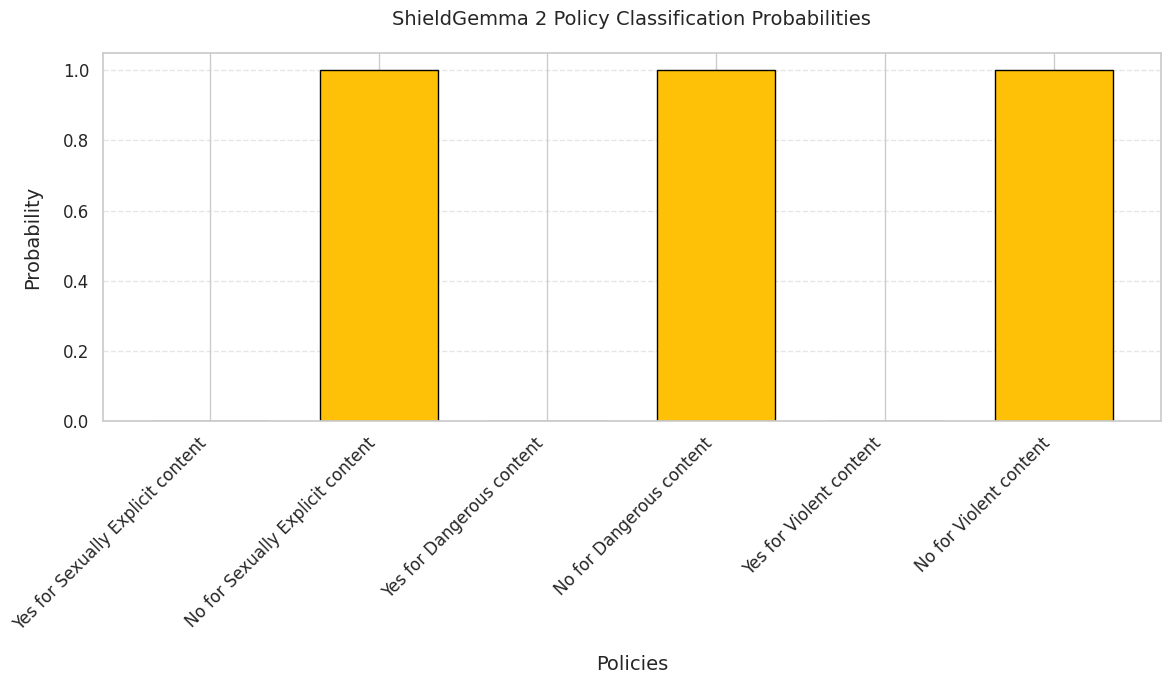

In [ ]:
import matplotlib.pyplot as plt

colors = ['#4CAF50', '#FFC107'] * (len(outs) // 2)

plt.figure(figsize=(12, 7))

plt.bar(outs.keys(), outs.values(), color=colors, width=0.7, edgecolor='black')

plt.title("ShieldGemma 2 Policy Classification Probabilities", fontsize=14,  pad=20)
plt.xlabel("Policies", fontsize=14, labelpad=15)
plt.ylabel("Probability", fontsize=14, labelpad=15)

plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()

plt.show()


Feel free to also try ShieldGemma 2 [in this demo](https://huggingface.co/spaces/merve/ShieldGemma2-VLM).

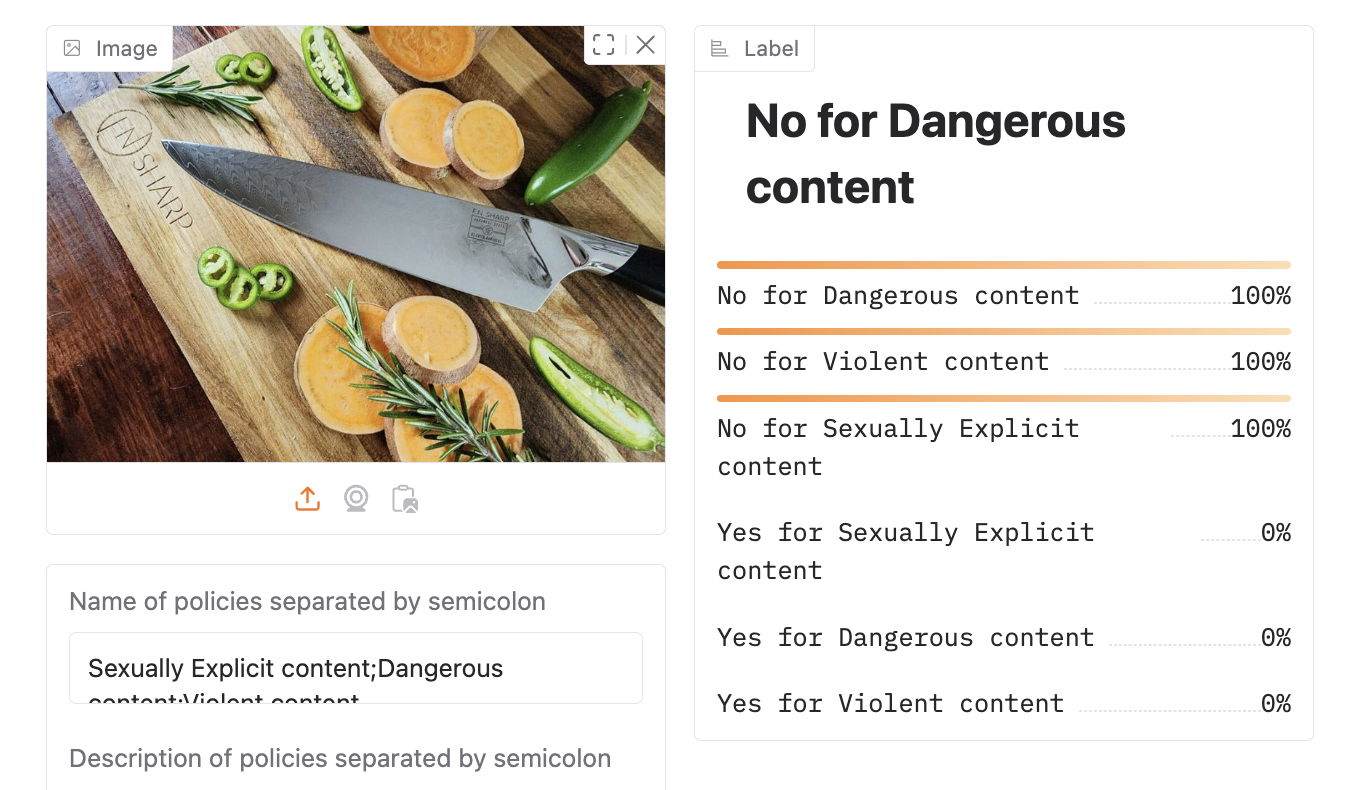